# **Fundamentals of Data Science: Assignment 2 - Telenet Case**

Academic year 2023 - 2024

**The assignment must be completed by a group of two students. Please provide the name and student number of each member below:**

Name Group Member 1: Aleksandr Medvedev

Student Number Group Member 1: 0572709

Name Group Member 2: Abdullah Amezian

Student Number Group Member 2: 0565316

**The assignment is graded based on:**

 * The quality of the code (code cells)
 * The explanation and reasoning of the steps (text cells)

**Make sure to understand both parts of the assignment well. Questions about your report and code will be asked during the oral exam.**

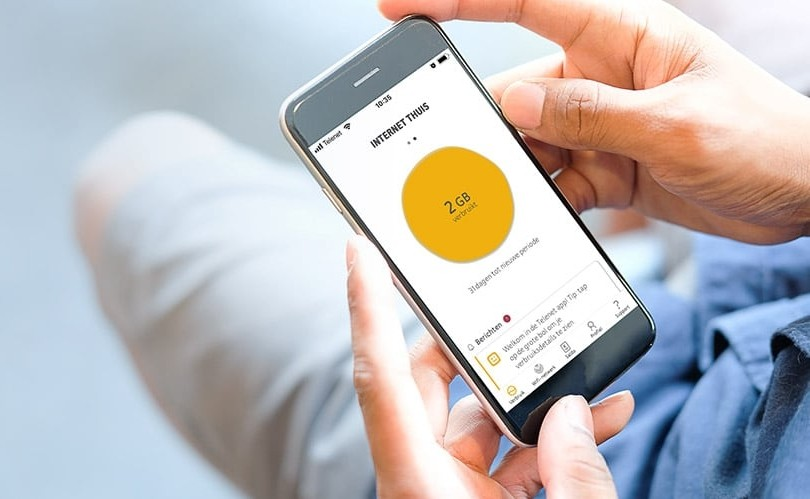

**Objective:** The goal of this assignment is to develop a data-based solution for Telenet. Assume the role of consultant, develop the technical solution, but also present a comprehensive report (inside the notebook) for Telenet management. This report should motivate all decisions and clearly link back to the business setting, and evaluate the expected business value. Assume that the target audience has FoDS level knowledge of data science.

For more information about the business case: lecture 9 (guest speakers Telenet) + carefully inspect the data documentation (see Canvas) + eventually check out their website:  https://www2.telenet.be/residential/nl/klantenservice/telenet-apps/  

Before you start: carefully read the PDF with instructions (see Canvas).


**Do not send any emails to Telenet for questions.**

## Step 1: Loading the data

Import the "Sep_2022.csv" and "Oct_2022.csv" files into your Google Colab environment. Run the cell below to import the data from September and October. After running this cell the data will be such that:

- September data only contains data from customers who were not active app users in September and did not churn in October.
- October data only contains data from customers who were not active app users in September and did not churn in October.
- The labels 'Never Used' and 'Sleeping User' were combined into the category 'Inactive User'. Therefore, the 'user_classification' column now only contains two categories.

! Make sure to adapt the file-path ("/content/Sep_2022.csv") when calling "read_csv" if necessary.

In [1]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# # Third-party library imports for Google Colab
# from google.colab import drive

# Third-party utility imports
from joblib import dump, load

# scikit-learn imports for preprocessing and imputation
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# scikit-learn imports for model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

# scikit-learn imports for model evaluation and optimization
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score,
    precision_score, f1_score, recall_score, RocCurveDisplay
)

# imbalanced-learn imports for handling class imbalance
from imblearn.under_sampling import RandomUnderSampler

import time
import socket

# Capture the start time
start_time = time.time()

In [2]:
September_data=pd.read_csv("data_2022/Sep_2022.csv", low_memory=False, nrows=50000).query("user_classification == 'Never Used' or user_classification == 'Sleeping User'")
October_data=pd.read_csv("data_2022/Oct_2022.csv", usecols=["user_classification", 'ANON_CUSTOMER_NUMBER'], nrows=50000)
October_data=pd.merge(October_data, September_data["ANON_CUSTOMER_NUMBER"], how='inner', on='ANON_CUSTOMER_NUMBER')
October_data["user_classification"]=October_data['user_classification'].replace(['Never Used', 'Sleeping User'], 'Inactive User')
September_data=pd.merge(September_data, October_data["ANON_CUSTOMER_NUMBER"], how="inner", on='ANON_CUSTOMER_NUMBER')
September_data=September_data.drop_duplicates(subset=['ANON_CUSTOMER_NUMBER'])
October_data=October_data.drop_duplicates(subset=['ANON_CUSTOMER_NUMBER'])

## Step 2: Business Understanding

Provide a comprehensive explanation of the case based on the presentation from Telenet. Additionally, specify the key business questions you aim to address and justify why they are important. Conduct further research to gather additional information about the application.

**Write your answer here:**

The Telenet team approached us with a challenge. As a telecommunications company, maintaining customer satisfaction with their products is crucial for the business's health. To achieve this, Telenet aims to leverage targeted marketing and communication strategies that deliver customized messages to specific sub-groups of their audience. One of their primary tools for enabling this personalized approach is their app, which provides customers with on-the-go access to their account information, payment options, membership adjustments, and a platform for addressing inquiries. Ideally, the app should handle routine inquiries to prevent overwhelming their call center with questions that could be resolved through the app.

Telenet's goal is to encourage more customers to start using the app. By predicting which customers are likely to use the app in the coming month, we aim to help Telenet tackle this complex issue.

So, in this notebook we will be trying to answer the following question:

How many customers are projected to start using the Telenet app next month based on our predictive analysis?

Predicting the number of new app users helps Telenet to effectively plan and allocate resources towards customer support, infrastructure, and marketing efforts. Knowing the expected increase in app usage allows for proactive adjustments to ensure the app's performance and support systems can handle the influx without degradation of service. Additionally, this metric serves as a baseline to measure the success of ongoing and future promotional activities aimed at boosting app engagement. It also helps in setting targeted goals for customer acquisition strategies and in understanding the effectiveness of recent improvements made to the app.

It's important to note that the dataset we have is biased since it only includes data from users who consented to data collection. This limitation affects the generalizability of our machine learning algorithm. To enhance the representativeness of our analysis, we would need truly random data from all Telenet customers, not just those who have consented.

Currently, we cannot accurately measure the direct impact of targeted communication strategies due to a lack of data. Understanding the treatment effect is vital as it sheds light on the effectiveness of the company's communication efforts. Gaining insights into how targeted actions influence app usage could help us devise more effective strategies for future engagement.

For instance, we could explore various targeting channels such as phone calls, emails, push notifications, and personalized letters. If we had binary data on whether customers were targeted, we could model the probability of app usage in the future with or without targeting, denoted as P(U | x, T) and P(U | x, ¬T) respectively, where T represents targeting, x represents a specific customer or household, and U denotes app usage for the next month.

Using some basic calculations, we could model the expected benefit of targeting, which can then be incorporated into the training data:

**Expected value of targetin**g = Δ(𝑃) ×  𝑢(𝑥) − 𝑐

Where Δ(P) is the change in the probability of app usage due to targeting, u(x) is the expected profit from app usage, and 𝑐 c is the cost associated with targeting.

It is crucial to understand that 'profit' here does not necessarily refer to monetary value but could represent saved time, reduced call volumes, and other operational efficiencies.

In this notebook, we are taking a flexible approach to our predictive modeling, particularly in how we evaluate the performance of our models. Instead of defaulting to the common practice of prioritizing the accurate identification of the minority class in an imbalanced dataset, we are initially using weighted metrics. These metrics consider the importance of both the majority and minority classes proportionally. This approach aligns with the exploratory phase of our project, where our goal is to iteratively refine our models and evaluation criteria based on initial testing outcomes.

For instance, as we gather more insights and depending on the outcomes, Telenet may decide to focus more precisely on identifying users who are likely to use the app in the upcoming month. Should this shift occur, we may adjust our metrics accordingly, potentially moving away from weighted measures to those that focus more directly on predictive accuracy for specific user groups.

Later in this notebook, we will provide a detailed explanation of the F1 metric and how it is applied in our current context. This iterative and open-minded approach ensures our modeling strategy remains adaptable and aligned with Telenet's evolving business objectives.

## Step 3: Data Understanding

**A) Pandas Dataframe methods**

Use at least three different methods from Pandas to gain some understanding of the data. Explain what you learn from each method below the corresponding code cell.

In [3]:
September_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40774 entries, 0 to 40773
Columns: 243 entries, MONTH_CODE to user_classification
dtypes: float64(141), int64(68), object(34)
memory usage: 75.6+ MB


In [4]:
September_data.head() # 243 columns

,MONTH_CODE,CUS_PRODMIX,CUS_LIFETIME,CUS_REVENUE_SEGMENT,CUS_SERVICE_SEGMENT,CUS_PAY_METHOD,CUS_FL_PACK_OWNERSHIP,CUS_PACKID,CUS_PROMOTION,CUS_PROMOTION_DETAIL,...,MTEL_FL_KONG_SURF,MTEL_FL_KING_SURF,MTEL_FL_SMS_5,MTEL_FL_SSM,MTEL_FL_PORT_IN,MTEL_FL_TRIIING,MTEL_TRIIING_LIFETIME_DAYS,MTEL_TRIIING_SOU,ANON_CUSTOMER_NUMBER,user_classification
0,202209,ATV_DTV_INT_TEL_MTEL,237.0,Residential,Residential,DOMI,1,16601.0,WIGO S 6GB,WIGO S 6GB INT,...,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,uyiskqns,Never Used
1,202209,ATV_DTV_INT_TEL_MTEL,255.0,Residential,Residential,DOMI,1,10125.0,Whoppa,"Whoppa korting t.w.v. €44,76/maand, incl. btw",...,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,tycdjjxw,Sleeping User
2,202209,ATV_DTV_INT_TEL_MTEL,261.0,Residential,Residential,DOMI,1,17605.0,WIGO S 3GB (1 SIM),WIGO S 3GB INT (1 SIM),...,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,oicyrppc,Sleeping User
3,202209,ATV_DTV_INT,171.0,Residential,Residential,DOMI,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qygyxjeq,Sleeping User
4,202209,INT_MTEL_MINT,250.0,Residential,Residential,MIXED,0,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,dscqllpg,Never Used


In [5]:
October_data.head() # Only 2 columns

,ANON_CUSTOMER_NUMBER,user_classification
0,uyiskqns,Inactive User
1,tycdjjxw,Inactive User
2,oicyrppc,Inactive User
3,qygyxjeq,Active User
4,dscqllpg,Inactive User


In [6]:
September_data.nunique()

MONTH_CODE                        1
CUS_PRODMIX                      45
CUS_LIFETIME                    295
CUS_REVENUE_SEGMENT               2
CUS_SERVICE_SEGMENT               1
                              ...  
MTEL_FL_TRIIING                   2
MTEL_TRIIING_LIFETIME_DAYS     1583
MTEL_TRIIING_SOU                  1
ANON_CUSTOMER_NUMBER          40774
user_classification               2
Length: 243, dtype: int64

In [7]:
September_data.describe()

,MONTH_CODE,CUS_LIFETIME,CUS_FL_PACK_OWNERSHIP,CUS_PACKID,CUS_AGE,CUS_CRT_TIMELAG,CUS_FL_PROX_PREFIX,CUS_FL_TN_EMAIL_USER,CUS_FL_ATV,CUS_FL_DTV,...,MTEL_PCT_VOL_4G,MTEL_OOB_TOTAL,MTEL_FL_KONG_SURF,MTEL_FL_KING_SURF,MTEL_FL_SMS_5,MTEL_FL_SSM,MTEL_FL_PORT_IN,MTEL_FL_TRIIING,MTEL_TRIIING_LIFETIME_DAYS,MTEL_TRIIING_SOU
count,40774.0,39590.000000,40774.000000,24581.000000,40396.000000,40774.000000,40774.000000,40774.000000,40774.000000,40774.000000,...,18130.000000,18130.000000,18130.000000,18130.000000,18130.000000,18130.000000,18130.000000,18130.000000,2933.000000,2933.0
mean,202209.0,136.247487,0.602860,15596.780603,60.883825,17.789449,0.453475,0.449649,0.875166,0.853804,...,75.102318,224.122504,0.003640,0.005130,0.000552,0.007887,0.923331,0.161776,2409.763382,0.0
std,0.0,73.235882,0.489312,3807.999571,16.982405,69.589090,0.497837,0.497464,0.330535,0.353307,...,37.417496,1142.955270,0.060227,0.071439,0.023480,0.088463,0.266072,0.368255,675.342767,0.0
min,202209.0,0.000000,0.000000,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,517.000000,0.0
25%,202209.0,76.000000,0.000000,16285.000000,49.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2006.000000,0.0
50%,202209.0,144.000000,1.000000,16581.000000,62.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2430.000000,0.0
75%,202209.0,193.000000,1.000000,18205.000000,74.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,100.000000,50.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3011.000000,0.0
max,202209.0,294.000000,1.000000,18645.000000,100.000000,456.000000,1.000000,1.000000,1.000000,1.000000,...,100.000000,61299.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3494.000000,0.0


**Explanation:** We can see that the September data set has 242 features that we can learn, obviously not all of them are relevant, so some of the information will be removed. Most of the data seems to be represented in the float format. The data is unscaled thus having great variations in their descriptive statistics (the mean and standard deviation vary greatly from column to column)

From nunique() method we can also observe that some columns act as flags (having 0 and 1 to indicate a certain property), as well as regular numerical columns with many unique values.

There are some object data types present suggesting that there is mixed content in the data set. (strings and integers can be mixed up together in one cell)

**B) Matplotlib Visualization**

Make at least three different plots (at least one pie chart and one scatter plot) with Matplotlib.pyplot to visualize the data and gain interesting insights for the case and/or the models. Explain what you learn from each plot below the corresponding code cell.  

Text(0, 0.5, '')

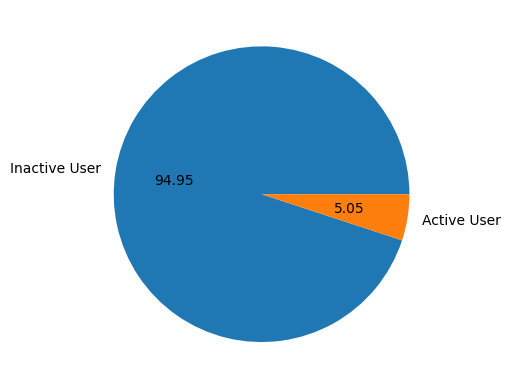

In [8]:
# Unbalanced classes issue - target column
October_data["user_classification"].value_counts().plot.pie(autopct = '%.2f')
# Remove the y-axis label
plt.ylabel('') 

Text(0, 0.5, 'Count')

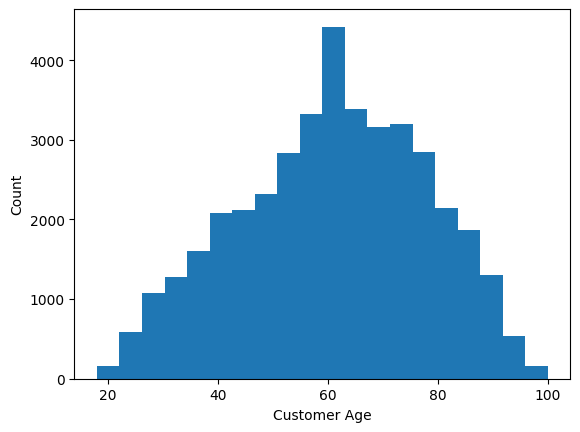

In [9]:
plt.hist(September_data['CUS_AGE'], bins = 20)
plt.xlabel('Customer Age')  # Add a label to the x-axis
plt.ylabel('Count')  # Add a label to the y-axis

Text(0, 0.5, 'Number of Yelo App Sessions')

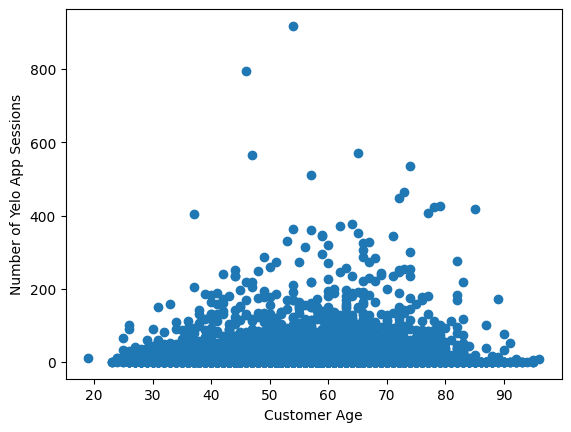

In [10]:
plt.scatter(September_data['CUS_AGE'], September_data['NR_YELO_SESSIONS_APP'])# Number of Yelo logins by app
plt.xlabel('Customer Age')  # Add a label to the x-axis
plt.ylabel('Number of Yelo App Sessions')  # Add a label to the y-axis

**Explanation:** The given plots give us valuable insights into the data set. First the classes in our target column are unbalanced, hinting at additional pre processing for better generalization results. For example, we would consider oversampling the under represented class.

Second we can immediately see that the majority of the customers are from 50 to 70 years old, which should be taken into account when analysing the effectiveness of app usage given a certain age.

For example in the 3rd plot we can see the Yello app usage (sessions) plotted against the customer age, we can see that the mobile app usage doesnt seem to correlate with age, there are some outliers, but the majority of the data stays almsot uniformal. The concentration of data points near age of 60 can be explained by the histogram (plot 2), since the majority of the customers are in this age group, we have higher chances of observing outliers.


## Step 4: Preprocessing the data

Split the X and Y data by running the cell below. Make sure to drop the following columns from the X data: ['user_classification', 'MONTH_CODE', 'ANON_CUSTOMER_NUMBER', 'MINT_TARIFF', 'CUS_REGIO']

In [11]:
X=September_data.drop(['user_classification', 'MONTH_CODE', 'ANON_CUSTOMER_NUMBER', 'MINT_TARIFF', 'CUS_REGIO'], axis=1)
y=October_data["user_classification"]

In [12]:
pd.set_option('display.max_rows', 300) # We want to be able to see missing values for all columns, if you want to turn this off: run pd.set_option('display.max_rows', 60) in another cell once (this is the default value for pandas)
X.isna().sum()

CUS_PRODMIX                         0
CUS_LIFETIME                     1184
CUS_REVENUE_SEGMENT                 0
CUS_SERVICE_SEGMENT                 0
CUS_PAY_METHOD                      0
CUS_FL_PACK_OWNERSHIP               0
CUS_PACKID                      16193
CUS_PROMOTION                   16193
CUS_PROMOTION_DETAIL            16193
CUS_CABLE_OWNER                    55
CUS_PROVINCIE                      16
CUS_SEX                             0
CUS_AGE                           378
CUS_LANGUAGE                        0
CUS_LIFESTAGE                    1375
CUS_LIFESTAGE_DETAILS            1375
CUS_CRT_TIMELAG                     0
CUS_FL_PROX_PREFIX                  0
CUS_FL_TN_EMAIL_USER                0
CUS_FL_ATV                          0
CUS_FL_DTV                          0
CUS_FL_INT                          0
CUS_FL_MINT                         0
CUS_FL_MTEL                         0
CUS_FL_TEL                          0
CUS_USER_IS_PAYER                   0
CUS_FL_MULTI

In [13]:
y.isna().sum()

np.int64(0)

### Missing Values

**4A Missing values**

It is up to you to apply the convenient imputing transformations to the correct columns and **explain how you made your choice**. In the end, make sure to join the processed columns back with the original dataframe.

Below you find help-code that saves column names based on the number of different values and Nan values occuring in each collumns and is provided below. Feel free to use/ignore/adapt it.

In [14]:
categorical_OK=[]   # categorical values without NaN
numerical_OK=[]     # Continuous variables without NaN
categorical_tobeimputed=[] # categorical variables with many NAN values
numerical_NAN=[]  # Continuousvariables with NaN values

data = X

#this code assumes the data you want to preprocess is called "data"
for column in data.columns:
  if data[column].isnull().sum()==0:   # If true, then NO NaN values, so column added to numerical_OK or categorical_OK
    if data[column].nunique() > 10:   #if number of unique values higher than 10, we put it in the numerical_OK list
        numerical_OK.append(column)
    elif data[column].nunique() <10:
        categorical_OK.append(column)
  else: # if NAN values do exist then run the code below
    if data[column].nunique() > 10:
      if pd.api.types.is_numeric_dtype(data[column]):
        numerical_NAN.append(column)
    elif data[column].nunique() <10:
      categorical_tobeimputed.append(column)


In [15]:
# Removing the 'VBS_' prefix
X['CUS_VALUE_SEGMENT'] = X['CUS_VALUE_SEGMENT'].str.replace('VBS_', '')

# Convert column to numeric
X['CUS_VALUE_SEGMENT'] = pd.to_numeric(X['CUS_VALUE_SEGMENT'])

In [16]:
#Categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')

columns_to_impute = [
    'TEL_TIER',
    'CUS_CABLE_OWNER',
    'CUS_VALUE_SEGMENT',
    'ATV_NR_LINES',
    'ATV_FL_BILL',
    'ATV_FL_BILL_LAG',
    'DTV_NR_LINES',
    'DTV_FL_PACK_SVOD',
    'DTV_FL_PACK_THEMATIC',
    'DTV_FL_PACK_PLUS_PAKKET',
    'DTV_FL_PACK_PRIME_FILM',
    'DTV_FL_PACK_PRIME_FILM_SPORT',
    'DTV_FL_PACK_SPORTING_TELENET',
    'DTV_FL_PACK_REX',
    'DTV_FL_PACK_RIO',
    'DTV_NR_SILENT_BOXES',
    'DTV_NR_BOXES',
    'DTV_FL_INTERACTIVE',
    'DTV_FL_CANAL_PLUS',
    'DTV_FL_DIGIBOX',
    'DTV_FL_DIGICORDER',
    'DTV_FL_HD_DIGIBOX',
    'DTV_FL_HD_DIGICORDER',
    'DTV_FL_BOX_AANKOOP',
    'DTV_FL_BOX_HUUR',
    'DTV_FL_BOX_THIRDPARTY',
    'DTV_FL_OVERALL_SILENT',
    'DTV_FL_CI_PLUS',
    'TEL_NR_LINES',
    'TEL_FL_PORTIN',
    'TEL_FL_VAS_FR24',
    'TEL_FL_VAS_OPTANY',
    'TEL_FL_TRIIING',
    'MTEL_NR_LINES',
    'MTEL_FL_RECURRING',
    'MTEL_FL_HANDSET',
    'MTEL_NR_DROPPED_CALLS_ORG',
    'MTEL_NR_DROPPED_CALLS_TERM',
    'MTEL_NR_DROPPED_CALLS_TOTAL',
    'MTEL_FL_KONG_SURF',
    'MTEL_FL_KING_SURF',
    'MTEL_FL_SMS_5',
    'MTEL_FL_SSM',
    'MTEL_FL_PORT_IN',
    'MTEL_FL_TRIIING',
    'MTEL_TRIIING_SOU',
    'DTV_NR_VOTING',
    'DTV_REV_VOTING',
    'TEL_TRIIING_SOU',
    'CUS_PROVINCIE',
    'CUS_LANGUAGE',
    'CUS_LIFESTAGE',
    'ATV_SALES_CHANNEL',
    'DTV_SALES_CHANNEL',
    'DTV_FL_PACK_PASSION',
    'INT_SALES_CHANNEL',
    'TEL_TARIFF',
    'TEL_SALES_CHANNEL',
    'MTEL_SALES_CHANNEL'
]


X[columns_to_impute] = categorical_imputer.fit_transform(X[columns_to_impute])

columns_drop =[
    'NR_YELO_LOGINS',
    'NR_YELO_LOGINS_PC',
    'NR_YELO_LOGINS_APP',
    'YELO_REC_FL',
    'INT_VOL_P2P_SIP',
    'INT_VOL_PYG',
    'INT_NR_LINES',
    'INT_HITMONTHS_1M',
    'INT_HITMONTHS_3M',
    'INT_HITMONTHS_6M',
    'INT_HITMONTHS_1YR',
    'INT_VOL_MAIL',
    'INT_VOL_NEWS',
    'MINT_NR_LINES',
    'MINT_SALES_CHANNEL',
    'MINT_SALES_CHANNEL_DETAIL',
    'CUS_LIFESTAGE_DETAILS',
    'CUS_PROMOTION',
    'CUS_PROMOTION_DETAIL',
    'ATV_SALES_CHANNEL_DETAIL',
    'DTV_SALES_CHANNEL_DETAIL',
    'INT_TIER',
    'INT_SALES_CHANNEL_DETAIL',
    'TEL_SALES_CHANNEL_DETAIL',
    'MTEL_SALES_CHANNEL_DETAIL',
    'MTEL_TARIFF'
]

X = X.drop(columns_drop, axis = 1)

In [17]:
# Numerical columns
numerical_imputer = SimpleImputer(strategy='mean')

columns_to_impute = [
  'CUS_LIFETIME',
  'CUS_AGE',
  'ATV_LIFETIME',
  'DTV_LIFETIME',
  'DTV_NR_DAYPASSES_12M',
  'DTV_NR_TRX_TOT',
  'DTV_NR_VOD',
  'DTV_NR_FREE_VOD',
  'DTV_NR_SVOD',
  'DTV_NR_TVOD',
  'DTV_NR_VOD_3M',
  'DTV_NR_FREE_VOD_3M',
  'DTV_NR_SVOD_3M',
  'DTV_NR_TVOD_3M',
  'DTV_NR_VOD_1YR',
  'DTV_NR_FREE_VOD_1YR',
  'DTV_NR_SVOD_1YR',
  'DTV_NR_TVOD_1YR',
  'DTV_REV_TRX_TOT',
  'DTV_REV_VOD',
  'DTV_REV_TVOD',
  'DTV_PACKAGE_LIFETIME',
  'DTV_BOX_LIFETIME',
  'TEL_LIFETIME',
  'TEL_INB_CNT',
  'TEL_INB_CONTACTS',
  'TEL_INB_MOU',
  'TEL_OUT_CNT',
  'TEL_OUT_CONTACTS',
  'TEL_OUT_MOU',
  'TEL_TOT_CONTACTS',
  'TEL_TOT_LASTUSAGE',
  'TEL_TOT_USAGEDAYS',
  'TEL_TRIIING_LIFETIME_DAYS',
  'MTEL_LIFETIME',
  'MTEL_USAGEDAYS',
  'MTEL_LASTUSAGE',
  'MTEL_CONTACTS',
  'MTEL_VOICE_CNT',
  'MTEL_VOICE_MOU',
  'MTEL_SMS_CNT',
  'MTEL_DATA_CNT',
  'MTEL_DATA_VOL',
  'MTEL_MMS_CNT',
  'MTEL_NO_2G_SESSIONS',
  'MTEL_NO_3G_SESSIONS',
  'MTEL_NO_4G_SESSIONS',
  'MTEL_TOT_NO_SESSIONS',
  'MTEL_PCT_SESSIONS_2G',
  'MTEL_PCT_SESSIONS_3G',
  'MTEL_PCT_SESSIONS_4G',
  'MTEL_VOL_2G_MB',
  'MTEL_VOL_3G_MB',
  'MTEL_VOL_4G_MB',
  'MTEL_TOT_VOL_MB',
  'MTEL_PCT_VOL_2G',
  'MTEL_PCT_VOL_3G',
  'MTEL_PCT_VOL_4G',
  'MTEL_OOB_TOTAL',
  'MTEL_TRIIING_LIFETIME_DAYS'
]

X[columns_to_impute] = numerical_imputer.fit_transform(X[columns_to_impute])

columns_drop =[
  'CUS_PACKID',
  'INT_LIFETIME',
  'INT_LASTUSAGE',
  'INT_NR_VOLBLOCKS',
  'INT_USAGEDAYS',
  'INT_VOL_DOWN',
  'INT_VOL_FTP',
  'INT_VOL_HTTP',
  'INT_VOL_OTHER',
  'INT_VOL_STREAMING',
  'INT_VOL_TOT',
  'INT_VOL_UP',
  'MINT_LIFETIME',
  'NR_YELO_SESSIONS',
  'NR_YELO_SESSIONS_PC',
  'NR_YELO_SESSIONS_APP',
  'DUR_YELO_SESSION_SEC',
  'DUR_YELO_SESSION_SEC_PC',
  'DUR_YELO_SESSION_SEC_APP'
  ]

X = X.drop(columns_drop, axis = 1)

In [18]:
#internet column
int_imputer = SimpleImputer(strategy = 'constant', fill_value = 2)

columns_to_impute = ['INT_FL_VOLBLOCK']
X[columns_to_impute] = int_imputer.fit_transform(X[columns_to_impute])

In [19]:
X.isna().sum()

CUS_PRODMIX                     0
CUS_LIFETIME                    0
CUS_REVENUE_SEGMENT             0
CUS_SERVICE_SEGMENT             0
CUS_PAY_METHOD                  0
CUS_FL_PACK_OWNERSHIP           0
CUS_CABLE_OWNER                 0
CUS_PROVINCIE                   0
CUS_SEX                         0
CUS_AGE                         0
CUS_LANGUAGE                    0
CUS_LIFESTAGE                   0
CUS_CRT_TIMELAG                 0
CUS_FL_PROX_PREFIX              0
CUS_FL_TN_EMAIL_USER            0
CUS_FL_ATV                      0
CUS_FL_DTV                      0
CUS_FL_INT                      0
CUS_FL_MINT                     0
CUS_FL_MTEL                     0
CUS_FL_TEL                      0
CUS_USER_IS_PAYER               0
CUS_FL_MULTI_ADDRESS            0
CUS_VALUE_SEGMENT               0
NR_TOT_CONT_LM                  0
NR_ADMIN_CONT_LM                0
NR_AFSPR_CONT_LM                0
NR_FACT_CONT_LM                 0
NR_GN_SUPP_CONT_LM              0
NR_PROD_TARIV_

**Please describe the methods you used for different types of columns and why you chose those methods instead of others:**

Using the helper code we have analysed the columns that needed to be imputed, which were broken into 2 categories: categorical and numerical.

We have investigated each of the columns by using info(), describe(), nunique() methods to come up with the imputation strategy.

For the categorical columns we have chose the 'most frequent' imputer to preserve the integer nature of the data set and to be able to impute the categorical columns with text, the columns mainly consisted of flags / types of sales channels. Some of the columns were dropped due to the fact that there were more than 70% missing values or because the column represented a description of a feature that we already implemented in the learning data.

For the numerical data although most of the information is presented in the integer form (number of months) we have decided to use the mean as an imputation technique because this will allow us to pass continuous data after the model has been trained. If the algorithm learns that the amount of months are always well rounded data that would be an additional constrain on the model.

The only exceptional column was 'CUS_VALUE_SEGMENT' that required manual pre-processing by removing the 'VBS_' prefix in order to match the description provided in the excel sheet

It is important to mention that the helper code provided has not fully identified all columns wiht missing values, so we have double checked it with 'X.isna().sum()' code to include any additional columns that were missed by applying the same logic that was described above.

From the Telenets' lecture we know that in case of the internet usage NA values actually mean that the person has no internet subscription, therefore we can not simply impute the missing values. The numerical internet related ('INT') columns were dropped, while the categorical one were coded with a number 2 instead of NA.

Lastly we have also dropped the 'CUS_PACKID' column since it acts as an identifier and does not have any predictive power.



### Category Encoding

**4B Category Encoding**

Apply the necessary transformations to categorical columns.

Similar to step 4A, some help-code, that separates different kinds of columns based on the number of classes appearing in a column, is provided below. You can (but are not obliged to) use this code before you start encoding the necessary columns.  
**Explain in detail which encoders you used for which type of columns and why.**

In [20]:
columns_A=[]
columns_B=[]

data = X

# this code assumes that the data you are sorting is called "data".
for column in data.columns:
      if data[column].dtype == 'object':
          unique_values = data[column].nunique()
          if unique_values == 2:
            columns_A.append(column)
          elif unique_values > 100:
            columns_A.append(column)
          else:
            columns_B.append(column)


In [21]:
encoder = OrdinalEncoder()
OE_columns = [
'CUS_LANGUAGE',
'CUS_SERVICE_SEGMENT'
]

# Fitting the encoder and transforming the data
encoder.fit(X[OE_columns])
OE_encoded = encoder.transform(X[OE_columns])


# Creating the new DataFrame with the correct column names
OE_data = pd.DataFrame(OE_encoded, columns = OE_columns)

# Drop the original categorical columns from X
X = X.drop(OE_columns, axis=1)

# Concatenate the original DataFrame X with the new ordinal encoded DataFrame
X = pd.concat([X, OE_data], axis=1)

In [22]:
# Create a label encoder object
encoder = LabelEncoder()

# Manually setting the classes to ensure the desired mapping
encoder.classes_ = np.array(['Inactive User', 'Active User'])

# Convert to DataFrame if you want it as a DataFrame
y = pd.DataFrame(encoder.transform(y), columns=['user_classification'])

In [23]:
encoder = OneHotEncoder()
OHE_columns = [
  'CUS_PRODMIX',
  'CUS_REVENUE_SEGMENT',
  'CUS_PAY_METHOD',
  'CUS_CABLE_OWNER',
  'CUS_PROVINCIE',
  'CUS_SEX',
  'CUS_LIFESTAGE',
  'CUS_USER_IS_PAYER',
  'ATV_SALES_CHANNEL',
  'DTV_SALES_CHANNEL',
  'INT_SALES_CHANNEL',
  'TEL_TARIFF',
  'TEL_TIER',
  'TEL_SALES_CHANNEL',
  'MTEL_SALES_CHANNEL'
]

# Fitting the encoder and transforming the data
encoder.fit(X[OHE_columns])
OHE_encoded = encoder.transform(X[OHE_columns]).toarray()

# Getting the correct column names from encoder
columns = encoder.get_feature_names_out(OHE_columns)

# Creating the new DataFrame with the correct column names
OHE_data = pd.DataFrame(OHE_encoded, columns = columns)

# Drop the original categorical columns from X
X = X.drop(OHE_columns, axis=1)

# Concatenate the original DataFrame X with the new one-hot encoded DataFrame
X = pd.concat([X, OHE_data], axis=1)

**Justify your approach: clarify the transformation process for each column and specify why you opted for this method rather than alternatives:**

Using the helper code we investigated both the columns A and B and grouped them by the encoder type. We used ordinal and one hot encoder. When the column consisted out of 1 or 2 unique values we used ordinal encoder ('CUS_LANGUAGE','CUS_SERVICE_SEGMENT'). For the columns which were flags no additional encoding were needed, also columns which represented the number of lines did not go through additional pre processing.

Columns 'CUS_PRODMIX', 'CUS_REVENUE_SEGMENT', 'CUS_PAY_METHOD',
'CUS_CABLE_OWNER','CUS_PROVINCIE','CUS_SEX','CUS_LIFESTAGE', 'CUS_USER_IS_PAYER', 'ATV_SALES_CHANNEL', 'DTV_SALES_CHANNEL','INT_SALES_CHANNEL', 'TEL_TARIFF', 'TEL_TIER', 'TEL_SALES_CHANNEL', 'MTEL_SALES_CHANNEL' were subject to one hot encoding due to the fact that the different unique values could not be represented as 'distance', so it was better to code each of the values as 1 or 0.

The target column was binary encoded with 0 being the inactive user and 1 active user.

Lastly we have dropped the original features and replaced them with the encoded columns.

### Feature Scaling

**4C Feature Scaling**

If necessary, apply a method of choice to scale the features. Explain in detail why you think feature scaling is necessary, how you chose the method and which columns you transformed.

In [24]:
# Step 1: Select numeric columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Step 2: Filter for columns with more than 2 unique values
cols_to_scale = [col for col in numeric_cols if X[col].nunique() > 2]

In [25]:
# Dividing the dataset in 2 pieces: training set and test set, with a test size of 20% of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scaling

# Initialize scaled DataFrames by copying the original train and test sets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

We have decided to use standardization for our data preprocessing because it improves the performance of logistic regression. Standardization transforms the data so that it has a mean of 0 and a standard deviation of 1, which ensures that all features contribute equally to the model and enhances the efficiency of gradient-based optimization algorithms used in logistic regression.

Features with larger scales can dominate the gradient calculations, causing disproportionate updates to the model parameters. For example, if one feature ranges from 1 to 1000 and another from 0.01 to 1, the feature with the larger range will have a greater influence on the gradient, skewing the optimization process.

Although standardization does not inherently assume that all variables follow a normal distribution, it tends to be more effective when the data is approximately normally distributed. This is because the standardization process (centering and scaling) works best when the data has a bell-shaped distribution.

Moreover, while standardization is crucial for logistic regression, it does not negatively affect decision trees. These tree-based models are inherently scale-invariant, meaning their performance remains consistent regardless of the feature scales. Thus, standardizing the data ensures that logistic regression performs optimally without impacting the efficacy of decision trees.

We have applied our scaler only to numerical columns that have a lot of unique values, since it doesnt make sense to apply the scaling to the binary columns

Important categorical column 'CUS_VALUE_SEGMENT' will not be subject to scaling since it represents distinct customer groups.


### Undersampling

Random undersampling: This technique reduces the presence of the majority class by randomly removing samples until the desired class balance is achieved. It is effective for models like logistic regression that perform poorly on imbalanced datasets. However, excessive reduction risks losing valuable data, as important patterns from the majority class might not be adequately captured.

We have decided to go with undersampling because the large amount of data that we have allows us to do so.

Since data from the majority class is being removed, obtaining a 50/50 proportion could be detrimental because it might lead to a significant loss of information and potential underfitting. Therefore, we have decided to go with a 35% ratio of the minority class to the majority class after several trials and errors based on the results of the F1 score. This balance helps to preserve enough data while striving to improve model performance on the minority class.

In [26]:
# Printing class proportions before undersampling
print("Class proportions before undersampling:")
print(y_train.value_counts(normalize=True), '\n')

# Undersampling of the majority class using RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.35)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

# Print class proportions after undersampling
print("Class proportions after undersampling:")
print(y_train_resampled.value_counts(normalize=True))

Class proportions before undersampling:
user_classification
0                      0.949355
1                      0.050645
Name: proportion, dtype: float64 

Class proportions after undersampling:
user_classification
0                      0.740741
1                      0.259259
Name: proportion, dtype: float64


In [27]:
# This step transforms the pandas dataframe to an array by first getting the values and putting them into a single array using ravel() method
# It is necessary for the optimisation stage to work properly
y_train_resampled = y_train_resampled.values.ravel()

## Step 5: Modeling

In this part of the notebook, write the code that **builds**, **trains** and **optimizes** three different prediction models. Motivate your choices and optimization techniques. Train three distinct supervised learning algorithms, choosing from those used during the exercise sessions.

**Discuss the rationale behind your algorithm selection and outline their respective advantages and disadvantages for this application.**

**Which models will you train? Why?**

Given the classification nature of our problem and the presence of class imbalance in our target variable, careful consideration was given to the choice of algorithms and their respective optimization strategies. After experimenting with five models — Logistic Regression, Decision Trees, Random Forest, Ada Boost, and a Stacking Classifier combining Logistic Regression and Ada Boost — we have selected the following three for their particular strengths and compatibility with our dataset's characteristics:

**Logistic Regression**: This model was chosen primarily for its efficiency and effectiveness in scenarios involving binary classification and linear relationships between features. Its performance is significantly enhanced by feature scaling, which is crucial as we've standardized our training data. Logistic Regression is straightforward to implement and interpret but may struggle with non-linear decision boundaries and complex relationships in data.

**Ada Boost Classifier**: Ada Boost helps improve the performance of decision trees by focusing on difficult cases, adapting iteratively to the misclassified examples in the training data. This makes it powerful for classification problems like ours where class imbalance is evident. However, Ada Boost can be sensitive to noisy data and outliers, which could potentially lead to overfitting.

**Stacking Classifier**: Combining Logistic Regression and Ada Boost, this model leverages the strengths of both. The stacking approach uses Logistic Regression as the final estimator, benefiting from the standardized features, and it generally produces better predictive performance by blending different models. The primary disadvantage here is the increased complexity and computational cost due to training multiple layers of models.

The rationale behind these selections stems from their complementary advantages. Logistic Regression offers a solid baseline with its responsiveness to scaled features. Ada Boost addresses the class imbalance by emphasizing harder-to-classify instances. Finally, the Stacking Classifier harnesses the collective capabilities of both models, potentially offsetting their individual weaknesses.

### Logistic Regression

**Model 1**: build, train, optimize the first "type" of model below.

In [28]:
# Building the Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=5000)

# Fitting the Logistic Regression on the resampled training data
log_reg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=5000, random_state=42)

In [29]:
# Optimisation
# Define the parameter grid
param_grid = {
    'penalty': ['l2'],  # Type of regularization solver lbfgs can only take l2 or none
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'max_iter': [5000]  # Maximum number of iterations taken for the solvers to converge
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, verbose=1, scoring= "f1_weighted")

# Fit the grid search to the data
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=5000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [5000], 'penalty': ['l2']},
             scoring='f1_weighted', verbose=1)

In [30]:
# Fitting optimised model
best_clf = grid_search.best_estimator_
best_clf.fit(X_train_resampled,y_train_resampled)

LogisticRegression(C=0.1, max_iter=5000, random_state=42)

### AdaBoost

In [31]:
# Create the AdaBoost classifier
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                               n_estimators=125, random_state=42, learning_rate=0.01)

# Train the model
ada_model.fit(X_train_resampled, y_train_resampled)

C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   learning_rate=0.01, n_estimators=125, random_state=42)

In [32]:
# AdaBoost with DecisionTree as the base estimator
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42) # class_weight='balanced' ->  negatively affects the result

estimator = AdaBoostClassifier(estimator=base_estimator,
                               random_state=42)

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [100, 105, 110, 115, 120, 125, 130, 135, 140], # Number of estimators
    'learning_rate': [0.1, 0.2, 0.3, 0.4]# Learning rate
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid,
                           scoring='f1_weighted', cv=3, verbose=2)

# Assuming X_train_resampled and y_train_resampled are your dataset
# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=100; total time=  16.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=100; total time=  16.1s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=100; total time=  16.1s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=105; total time=  16.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=105; total time=  16.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=105; total time=  16.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=110; total time=  17.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=110; total time=  17.5s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=110; total time=  17.5s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=115; total time=  18.2s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=115; total time=  18.2s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=115; total time=  18.1s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=120; total time=  19.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=120; total time=  19.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=120; total time=  19.3s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=125; total time=  19.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=125; total time=  19.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=125; total time=  20.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=130; total time=  20.6s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=130; total time=  20.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=130; total time=  20.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=135; total time=  21.5s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=135; total time=  21.5s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=135; total time=  21.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=140; total time=  22.2s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=140; total time=  22.2s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.1, n_estimators=140; total time=  22.2s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=100; total time=  15.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=100; total time=  15.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=100; total time=  16.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=105; total time=  16.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=105; total time=  16.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=105; total time=  16.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=110; total time=  17.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=110; total time=  17.6s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=110; total time=  17.6s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=115; total time=  18.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=115; total time=  18.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=115; total time=  18.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=120; total time=  19.1s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=120; total time=  19.1s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=120; total time=  18.9s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=125; total time=  19.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=125; total time=  19.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=125; total time=  19.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=130; total time=  20.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=130; total time=  20.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=130; total time=  20.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=135; total time=  21.6s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=135; total time=  21.5s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=135; total time=  21.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=140; total time=  22.2s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=140; total time=  22.2s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.2, n_estimators=140; total time=  22.1s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=100; total time=  16.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=100; total time=  15.9s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=100; total time=  15.9s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=105; total time=  16.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=105; total time=  16.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=105; total time=  16.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=110; total time=  17.6s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=110; total time=  17.5s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=110; total time=  17.5s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=115; total time=  18.3s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=115; total time=  18.3s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=115; total time=  18.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=120; total time=  19.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=120; total time=  19.1s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=120; total time=  19.1s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=125; total time=  19.9s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=125; total time=  20.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=125; total time=  19.9s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=130; total time=  20.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=130; total time=  20.6s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=130; total time=  20.6s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=135; total time=  21.3s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=135; total time=  21.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=135; total time=  21.5s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=140; total time=  22.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=140; total time=  22.3s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.3, n_estimators=140; total time=  22.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=100; total time=  16.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=100; total time=  16.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=100; total time=  16.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=105; total time=  16.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=105; total time=  16.6s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=105; total time=  16.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=110; total time=  17.6s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=110; total time=  17.5s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=110; total time=  17.6s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=115; total time=  18.3s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=115; total time=  18.3s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=115; total time=  18.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=120; total time=  19.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=120; total time=  19.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=120; total time=  19.1s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=125; total time=  20.1s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=125; total time=  20.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=125; total time=  20.0s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=130; total time=  20.8s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=130; total time=  20.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=130; total time=  20.7s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=135; total time=  21.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=135; total time=  21.4s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=135; total time=  21.5s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=140; total time=  22.3s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=140; total time=  22.3s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.4, n_estimators=140; total time=  22.5s


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                                           random_state=42),
                                          random_state=42),
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'n_estimators': [100, 105, 110, 115, 120, 125, 130,
                                          135, 140]},
             scoring='f1_weighted', verbose=2)

In [33]:
# Best model after grid search
best_ada_model = grid_search.best_estimator_
# Train the model
best_ada_model.fit(X_train_resampled, y_train_resampled)

C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   learning_rate=0.3, n_estimators=125, random_state=42)

### Stacking AdaBoost and Logistic Regression

In [34]:
# Define base models
estimators = [
    ('adaboost', best_ada_model),
    ('logistic', best_clf)
]

# Create the Stacking classifier with a new logistic regression as the final estimator
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter = 1000), passthrough=True)

# Fit the stacking model
stack_model.fit(X_train_resampled, y_train_resampled)

C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

StackingClassifier(estimators=[('adaboost',
                                AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                                                    random_state=42),
                                                   learning_rate=0.3,
                                                   n_estimators=125,
                                                   random_state=42)),
                               ('logistic',
                                LogisticRegression(C=0.1, max_iter=5000,
                                                   random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000),
                   passthrough=True)

In [35]:
# Parameter grid for GridSearchCV
param_grid = {
    'final_estimator__C': [0.0001,0.001,0.01,0.1],  # Regularization strength
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=stack_model, param_grid=param_grid, cv=3,
                           scoring='f1_weighted', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END ..........................final_estimator__C=0.0001; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END ..........................final_estimator__C=0.0001; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END ..........................final_estimator__C=0.0001; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END ...........................final_estimator__C=0.001; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END ...........................final_estimator__C=0.001; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END ...........................final_estimator__C=0.001; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END ............................final_estimator__C=0.01; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END ............................final_estimator__C=0.01; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END ............................final_estimator__C=0.01; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END .............................final_estimator__C=0.1; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END .............................final_estimator__C=0.1; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

[CV] END .............................final_estimator__C=0.1; total time= 1.6min


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

GridSearchCV(cv=3,
             estimator=StackingClassifier(estimators=[('adaboost',
                                                       AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                                                                           random_state=42),
                                                                          learning_rate=0.3,
                                                                          n_estimators=125,
                                                                          random_state=42)),
                                                      ('logistic',
                                                       LogisticRegression(C=0.1,
                                                                          max_iter=5000,
                                                                          random_state=42))],
                                          final_estimator=LogisticRegression(max_iter=1000),
                                          passthrough=True),
             param_grid={'final_estimator__C': [0.0001, 0.001, 0.01, 0.1]},
             scoring='f1_weighted', verbose=2)

In [36]:
# Best model after grid search
best_stack_model = grid_search.best_estimator_

# Fit the stacking model
best_stack_model.fit(X_train_resampled, y_train_resampled)

C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

StackingClassifier(estimators=[('adaboost',
                                AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                                                    random_state=42),
                                                   learning_rate=0.3,
                                                   n_estimators=125,
                                                   random_state=42)),
                               ('logistic',
                                LogisticRegression(C=0.1, max_iter=5000,
                                                   random_state=42))],
                   final_estimator=LogisticRegression(C=0.1, max_iter=1000),
                   passthrough=True)

In [37]:
# Downloading the model, so that we don't have to train it again in the future
# list_of_feature_names = X_train_resampled.columns.tolist()
# dump({'model': best_stack_model, 'features': list_of_feature_names}, '/content/best_stack_model_with_features.joblib')

## Step 6: Evaluation

In [38]:
# Helper functions
def plot_cumulative_gain(y_test, y_scores, model_name, ax):
    # Ensure y_test and y_scores are numpy arrays
    y_test_array = np.array(y_test)
    y_scores_array = np.array(y_scores)

    # Total number of positives
    total_positives = np.sum(y_test_array)

    # Get the indices that would sort the scores
    sorted_indices = np.argsort(y_scores_array)[::-1]

    # Sort the actual values based on the indices
    sorted_y_test = y_test_array[sorted_indices]

    # Calculate cumulative sum of the true positives
    cum_true_positives = np.cumsum(sorted_y_test)

    # Calculate cumulative gain
    cumulative_gain = cum_true_positives / total_positives

    # Normalize cumulative gain for the y-axis
    cumulative_gain *= 100

    # Calculate the percentage of samples reviewed
    percent_sampled = np.linspace(0.01, 100, len(cumulative_gain))

    # Plotting
    ax.plot(percent_sampled, cumulative_gain, label=f'{model_name}')

    return cumulative_gain, percent_sampled


def plot_lift_curve(y_test, y_scores, model_name, ax, cumulative_gain, percent_sampled):
    baseline = np.maximum(percent_sampled, 0.1)  # Avoid division by zero or very low values
    cumulative_gain = np.maximum(cumulative_gain, 0.1)
    lift = cumulative_gain / baseline
    ax.plot(percent_sampled, lift, label=f'{model_name} Lift')
    ax.set_xlabel('Percentage of Population targeted')
    ax.set_ylabel('Lift')
    ax.set_title('Lift Curve')
    ax.legend()
    ax.grid(True)


In [39]:
# Probabilities for class = 1, Non optimised models
y_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]

y_prob_ada = ada_model.predict_proba(X_test_scaled)[:, 1]

y_prob_stack = stack_model.predict_proba(X_test_scaled)[:, 1]

In [40]:
# Probabilities for class = 1, Optimised models
y_prob_log_best = best_clf.predict_proba(X_test_scaled)[:, 1]

y_prob_ada_best = best_ada_model.predict_proba(X_test_scaled)[:, 1]

y_prob_stack_best = best_stack_model.predict_proba(X_test_scaled)[:, 1]

 Compare the performance of three different models. To do so, apply the models on a part of the September and October data. Think about which metrics you use and explain your reasoning/choices in detail why you made these choices.


In scenarios involving binary and unbalanced datasets, the weighted F1 score is frequently selected as the evaluation metric due to its tailored relevance. Unlike accuracy, which can be misleading in the presence of class imbalances, the weighted F1 score provides a more nuanced measure by balancing precision (the accuracy of positive predictions) and recall (the model's capability to capture all actual positives). The weighting aspect of this metric adjusts the score based on the class distribution, ensuring that each class's contribution to the score is proportional to its prevalence.

This characteristic makes the weighted F1 score particularly valuable for comparing the effectiveness of models in accurately predicting outcomes across both majority and minority classes.

ROC, Lift and Cumulative response serve as additional metrics that can also be informative for evaluating models in this context.

The area under the ROC curve (AUC) is particularly useful as it provides a single scalar value to compare models. An AUC of 1 indicates a perfect model, while an AUC of 0.5 suggests no discriminative power.

Lift Chart: The Lift chart is a measure of the effectiveness of a classification model calculated as the ratio of results obtained with the model to those obtainable without the model. It helps in understanding how much better one can expect to do with the predictive model compared to without it.

Cumulative Response Curve (CRC): This curve demonstrates the percentage of true positive cases captured versus the percentage of the total population contacted. This metric is crucial when resources are limited and you want to target as many positives as possible with the least effort. The steeper the CRC, the better the model is at identifying positive cases early on.

Before we start comparing the results we have to mention that the **evaluation results will vary depending on the amount of data loaded into the notebook**.

Logistic Regression: Initially, the model showed decent training and test accuracy, but it struggled with precision and recall, which was reflected in a moderate weighted F1 score. Post-optimization adjustments led to a slight decrease in training accuracy, which suggested reduced overfitting, and an improvement in test accuracy, indicating better generalization. Recall and precision improved, leading to a higher weighted F1 score. The adjustments also resulted in fewer false negatives and false positives.

AdaBoost: This model started with lower training accuracy compared to its test performance but exhibited limited effectiveness in identifying positive cases due to overfitting, as seen in the 0 recall and precision. After optimization, both training and test accuracies adjusted, while the weighted F1 metric reduced slightly, from the confusion matrix we saw an overall improvement in the identification of true positives.

Stacked Model: The stacked model demonstrated fair training and test accuracies initially, with modest precision and recall. Following optimization, both training and test accuracies saw improvements, along with better precision and recall, culminating in a higher weighted F1 score. The model also showed improved efficiency in reducing false positives and false negatives.

Overall the optimisation had minor effects on the performance of the models, yet we still believe it was an important step due to the nature of crossvalidation that averages the performance based on different training sets which should lead to an increase in generalization. In other words the individual non optimised models could've performed this good due to luck.

The exact results you can find below in the code section.

### ROC

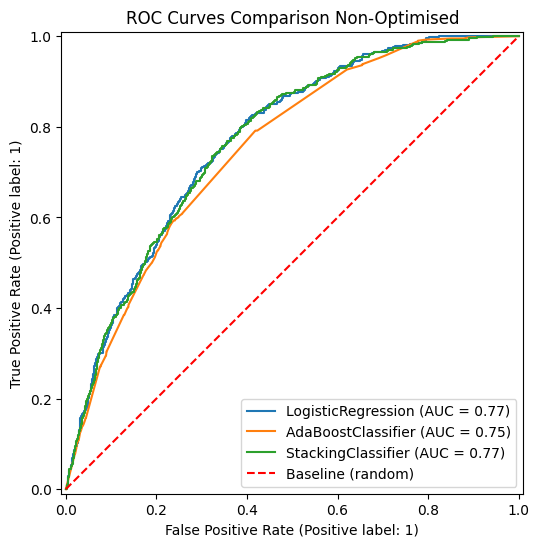

In [41]:
# ROC for non optimised results
fig, ax = plt.subplots(figsize=(10, 6))
RocCurveDisplay.from_estimator(log_reg, X_test_scaled, y_test, ax = ax)
RocCurveDisplay.from_estimator(ada_model, X_test_scaled, y_test, ax = ax)
RocCurveDisplay.from_estimator(stack_model, X_test_scaled, y_test, ax = ax)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Baseline (random)')
ax.set_title('ROC Curves Comparison Non-Optimised')
plt.legend(loc='lower right')

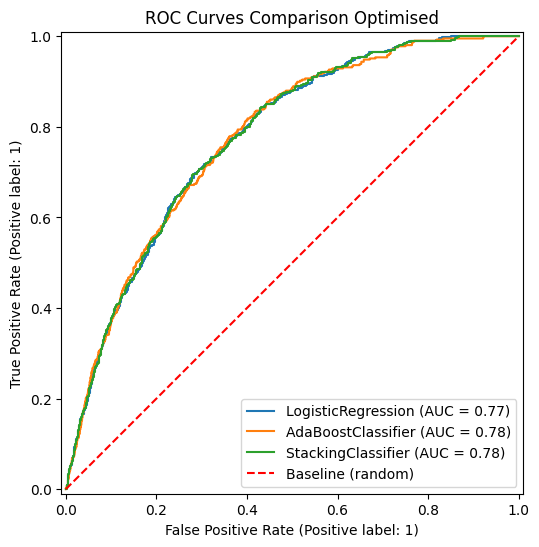

In [42]:
# ROC for optimised results
fig, ax = plt.subplots(figsize=(10, 6))
RocCurveDisplay.from_estimator(best_clf, X_test_scaled, y_test, ax = ax)
RocCurveDisplay.from_estimator(best_ada_model, X_test_scaled, y_test, ax = ax)
RocCurveDisplay.from_estimator(best_stack_model, X_test_scaled, y_test, ax = ax)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Baseline (random)')
ax.set_title('ROC Curves Comparison Optimised')
plt.legend(loc='lower right')

### Cumulative Response & Lift

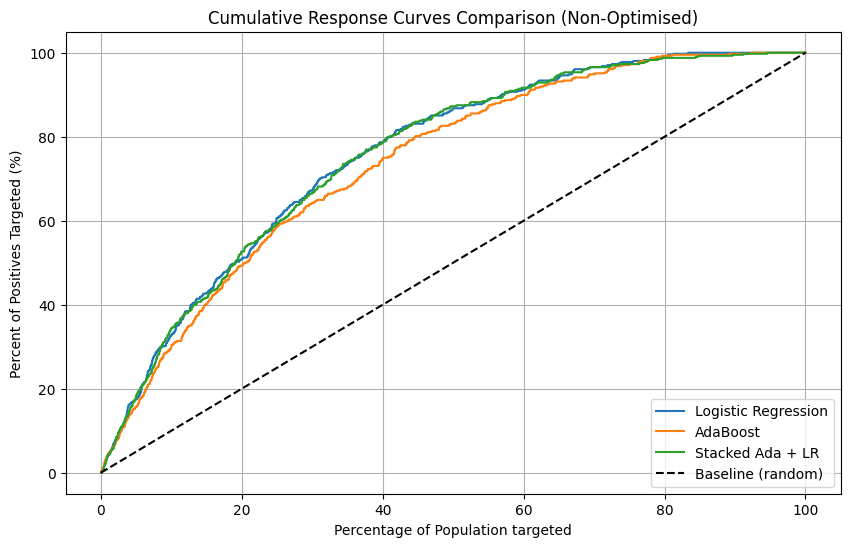

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))

#New variables for ease of use
model1 = y_prob_log
model4 = y_prob_ada
model5 = y_prob_stack

# Getting cumulative response curves
cr_log = plot_cumulative_gain(y_test, model1, 'Logistic Regression', ax)
cr_ada = plot_cumulative_gain(y_test, model4, 'AdaBoost', ax)
cr_stack = plot_cumulative_gain(y_test, model5, 'Stacked Ada + LR', ax)

# Plot baseline
ax.plot([0, 100], [0, 100], 'k--', label='Baseline (random)')

ax.set_xlabel('Percentage of Population targeted')
ax.set_ylabel('Percent of Positives Targeted (%)')
ax.set_title('Cumulative Response Curves Comparison (Non-Optimised)')
ax.legend(loc='lower right')
ax.grid(True)

plt.show()

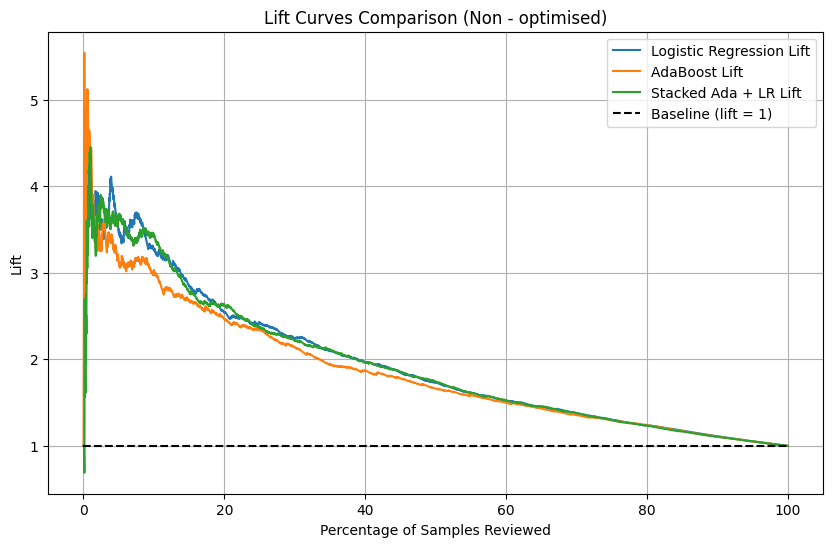

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_lift_curve(y_test, model1, 'Logistic Regression', ax, cr_log[0], cr_log[1])
plot_lift_curve(y_test, model4, 'AdaBoost', ax, cr_ada[0], cr_ada[1])
plot_lift_curve(y_test, model5, 'Stacked Ada + LR', ax, cr_stack[0], cr_stack[1])

# Plot the baseline at lift = 1
ax.plot([0, 100], [1, 1], 'k--', label='Baseline (lift = 1)')
ax.set_xlabel('Percentage of Samples Reviewed')
ax.set_ylabel('Lift')
ax.set_title('Lift Curves Comparison (Non - optimised)')
ax.legend(loc="upper right")
ax.grid(True)
plt.show()

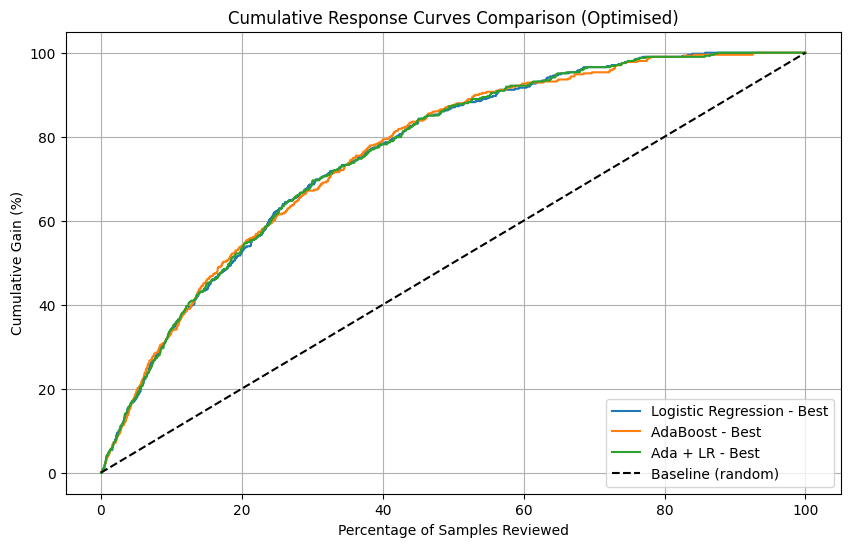

In [45]:
model1_opt = y_prob_log_best
model4_opt = y_prob_ada_best
model5_opt = y_prob_stack_best

fig, ax = plt.subplots(figsize=(10, 6))

cr_log_best = plot_cumulative_gain(y_test, model1_opt, 'Logistic Regression - Best', ax)
cr_ada_best = plot_cumulative_gain(y_test, model4_opt, 'AdaBoost - Best', ax)
cr_stack_best = plot_cumulative_gain(y_test, model5_opt, 'Ada + LR - Best', ax)

# Plot baseline
ax.plot([0, 100], [0, 100], 'k--', label='Baseline (random)')
ax.set_xlabel('Percentage of Samples Reviewed')
ax.set_ylabel('Cumulative Gain (%)')
ax.set_title('Cumulative Response Curves Comparison (Optimised)')
ax.legend(loc='lower right')
ax.grid(True)

plt.show()

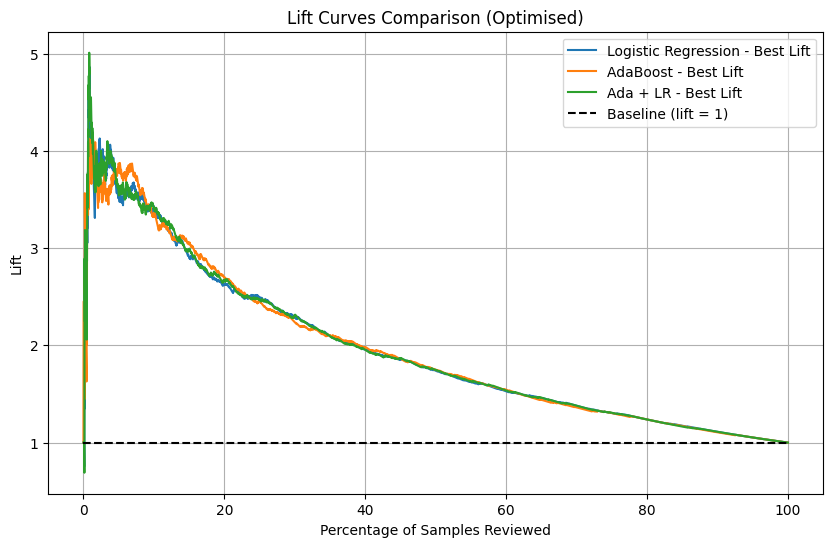

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

#Plotting lift curves
plot_lift_curve(y_test, model1_opt, 'Logistic Regression - Best', ax, cr_log_best[0], cr_log_best[1])
plot_lift_curve(y_test, model4_opt, 'AdaBoost - Best', ax, cr_ada_best[0], cr_ada_best[1])
plot_lift_curve(y_test, model5_opt, 'Ada + LR - Best', ax, cr_stack_best[0], cr_stack_best[1])

# Plot the baseline at lift = 1
ax.plot([0, 100], [1, 1], 'k--', label='Baseline (lift = 1)')
ax.set_xlabel('Percentage of Samples Reviewed')
ax.set_ylabel('Lift')
ax.set_title('Lift Curves Comparison (Optimised)')
ax.legend(loc="upper right")
ax.grid(True)
plt.show()

### Metrics

### Logistic Regression

In [47]:
# Non optimised results

# Predictions for evaluation metrics
y_pred_test = log_reg.predict(X_test_scaled)

# Evaluating the Logistic Regression and providing the corresponding scores and confusion matrix
train_score = log_reg.score(X_train_resampled, y_train_resampled)
test_score = log_reg.score(X_test_scaled, y_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Outputting results
print("LR Training Accuracy:", train_score)
print("LR Test Accuracy:", test_score)
print("LR Precision on Test Data:", test_precision)
print("LR Recall on Test Data:", test_recall)
print("LR Weighted F1 Score on Test Data:", test_f1)
print("LR Confusion Matrix on Test Data:")

# Flipping the order of the confusion matrix such that true positives are in the upper left corner
print(confusion_matrix(y_test, y_pred_test)[::-1, ::-1])

LR Training Accuracy: 0.7923728813559322
LR Test Accuracy: 0.8804414469650521
LR Precision on Test Data: 0.16129032258064516
LR Recall on Test Data: 0.33088235294117646
LR Weighted F1 Score on Test Data: 0.8993377786059213
LR Confusion Matrix on Test Data:
[[ 135  273]
 [ 702 7045]]


In [48]:
# Optimised results

# Predictions for evaluation metrics
y_pred_test = best_clf.predict(X_test_scaled)

# Evaluating the Logistic Regression and providing the corresponding scores and confusion matrix
train_score = best_clf.score(X_train_resampled, y_train_resampled)
test_score = best_clf.score(X_test_scaled, y_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Outputting results
print("LR - Best Training Accuracy:", train_score)
print("LR - Best Test Accuracy:", test_score)
print("LR - Best Precision on Test Data:", test_precision)
print("LR - Best Recall on Test Data:", test_recall)
print("LR - Best Weighted F1 Score on Test Data:", test_f1)
print("LR - Best Confusion Matrix on Test Data:")

# Flipping the order of the confusion matrix such that true positives are in the upper left corner
print(confusion_matrix(y_test, y_pred_test)[::-1, ::-1])

LR - Best Training Accuracy: 0.7876647834274952
LR - Best Test Accuracy: 0.8854690374003679
LR - Best Precision on Test Data: 0.16876574307304787
LR - Best Recall on Test Data: 0.3284313725490196
LR - Best Weighted F1 Score on Test Data: 0.9023956868895875
LR - Best Confusion Matrix on Test Data:
[[ 134  274]
 [ 660 7087]]


### AdaBoost

In [49]:
# Non optimised results

# Predictions for evaluation metrics
y_pred_test = ada_model.predict(X_test_scaled)

# Evaluating the AdaBoost and providing the corresponding scores and confusion matrix
train_score = ada_model.score(X_train_resampled, y_train_resampled)
test_score = ada_model.score(X_test_scaled, y_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Outputting results
print("ADA Training Accuracy:", train_score)
print("ADA Test Accuracy:", test_score)
print("ADA Precision on Test Data:", test_precision)
print("ADA Recall on Test Data:", test_recall)
print("ADA Weighted F1 Score on Test Data:", test_f1)
print("ADA Confusion Matrix on Test Data:")

# Flipping the order of the confusion matrix such that true positives are in the upper left corner
print(confusion_matrix(y_test, y_pred_test)[::-1, ::-1])

ADA Training Accuracy: 0.7540803515379787
ADA Test Accuracy: 0.9346413243408952
ADA Precision on Test Data: 0.1693121693121693
ADA Recall on Test Data: 0.0784313725490196
ADA Weighted F1 Score on Test Data: 0.9231088949451093
ADA Confusion Matrix on Test Data:
[[  32  376]
 [ 157 7590]]


In [50]:
# Optimised

# Predictions for evaluation metrics
y_pred_test = best_ada_model.predict(X_test_scaled)

# Evaluating the AdaBoost and providing the corresponding scores and confusion matrix
train_score = best_ada_model.score(X_train_resampled, y_train_resampled)
test_score = best_ada_model.score(X_test_scaled, y_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Outputting results
print("ADA - Best Training Accuracy:", train_score)
print("ADA - Best Test Accuracy:", test_score)
print("ADA - Best Precision on Test Data:", test_precision)
print("ADA - Best Recall on Test Data:", test_recall)
print("ADA - Best Weighted F1 Score on Test Data:", test_f1)
print("ADA - Best Confusion Matrix on Test Data:")

# Flipping the order of the confusion matrix such that true positives are in the upper left corner
print(confusion_matrix(y_test, y_pred_test)[::-1, ::-1])

ADA - Best Training Accuracy: 0.7873509102322661
ADA - Best Test Accuracy: 0.886940527283875
ADA - Best Precision on Test Data: 0.17051282051282052
ADA - Best Recall on Test Data: 0.32598039215686275
ADA - Best Weighted F1 Score on Test Data: 0.9032511308321273
ADA - Best Confusion Matrix on Test Data:
[[ 133  275]
 [ 647 7100]]


### Stacked AdaBoost and Logistic regression

In [51]:
# Non optimised results

# Predictions for evaluation metrics
stacked_predictions = stack_model.predict(X_test_scaled)

# Evaluating the Stacked model and providing the corresponding scores and confusion matrix
stack_train_score = stack_model.score(X_train_resampled, y_train_resampled)
stack_test_score = stack_model.score(X_test_scaled, y_test)
stack_precision = precision_score(y_test, stacked_predictions)
stack_recall = recall_score(y_test, stacked_predictions)
stack_f1 = f1_score(y_test, stacked_predictions, average='weighted')

# Outputting results
print("Stacked Model Training Accuracy:", stack_train_score)
print("Stacked Model Test Accuracy:", stack_test_score)
print("Stacked Model Precision on Test Data:", stack_precision)
print("Stacked Model Recall on Test Data:", stack_recall)
print("Stacked Model Weighted F1 Score on Test Data:", stack_f1)
print("Stacked Model Confusion Matrix on Test Data:")
print(confusion_matrix(y_test, stacked_predictions)[::-1, ::-1])

Stacked Model Training Accuracy: 0.7862523540489642
Stacked Model Test Accuracy: 0.8887798896382587
Stacked Model Precision on Test Data: 0.1721419185282523
Stacked Model Recall on Test Data: 0.32107843137254904
Stacked Model Weighted F1 Score on Test Data: 0.9042758157807348
Stacked Model Confusion Matrix on Test Data:
[[ 131  277]
 [ 630 7117]]


In [52]:
# Optimised results

# Predictions for evaluation metrics using the best model
best_predictions = best_stack_model.predict(X_test_scaled)

# Evaluating the Stacked model and providing the corresponding scores and confusion matrix
best_train_score = best_stack_model.score(X_train_resampled, y_train_resampled)
best_test_score = best_stack_model.score(X_test_scaled, y_test)
best_precision = precision_score(y_test, best_predictions)
best_recall = recall_score(y_test, best_predictions)
best_f1 = f1_score(y_test, best_predictions, average='weighted')

# Outputting results
print("Optimized Stacked Model Training Accuracy:", best_train_score)
print("Optimized Stacked Model Test Accuracy:", best_test_score)
print("Optimized Stacked Model Precision on Test Data:", best_precision)
print("Optimized Stacked Model Recall on Test Data:", best_recall)
print("Optimized Stacked Model Weighted F1 Score on Test Data:", best_f1)
print("Optimized Stacked Model Confusion Matrix on Test Data:")
print(confusion_matrix(y_test, best_predictions)[::-1, ::-1])

Optimized Stacked Model Training Accuracy: 0.7860954174513497
Optimized Stacked Model Test Accuracy: 0.8876762722256285
Optimized Stacked Model Precision on Test Data: 0.16927083333333334
Optimized Stacked Model Recall on Test Data: 0.31862745098039214
Optimized Stacked Model Weighted F1 Score on Test Data: 0.9035327292935902
Optimized Stacked Model Confusion Matrix on Test Data:
[[ 130  278]
 [ 638 7109]]


## Step 7: Deployment

In this stage, make sure you imported the Nov_2022.cv and "decembercustomer.csv" files. Run the cel below to ensure only the inactive customers (which re still customers in December) are selected. Then, use the best model to predict the target labels for December, based on the data of November. Explain in detail why you believe this model is the best one and explain what Telenet should do with the output. To do so, you can use data understanding techniques on these new predictions. Finally, insert the obtained target labels in the provided code and submit the corresponding CSV file to Canvas, along with the notebook.

In [53]:
November_data=pd.read_csv("/content/Nov_2022.csv",nrows = 50000, low_memory=False).query("user_classification == 'Never Used' or user_classification == 'Sleeping User'")
d_dec_ids=pd.read_csv("/content/decembercustomers.csv", nrows = 50000)
mask=November_data["ANON_CUSTOMER_NUMBER"].isin(d_dec_ids["ANON_CUSTOMER_NUMBER"])
November_data=November_data[mask]
X_dep=November_data.drop(['user_classification', 'MONTH_CODE', 'ANON_CUSTOMER_NUMBER', 'MINT_TARIFF', 'CUS_REGIO'], axis=1)

FileNotFoundError: [Errno 2] No such file or directory: '/content/Nov_2022.csv'

### Missing values

In [ ]:
# Get the names of columns that have missing values
columns_with_missing = X_dep.columns[X_dep.isna().any()].tolist()

# Provided list of columns already being preprocessed or dropped
columns_to_impute = [
    'TEL_TIER',
    'CUS_CABLE_OWNER',
    'CUS_VALUE_SEGMENT',
    'ATV_NR_LINES',
    'ATV_FL_BILL',
    'ATV_FL_BILL_LAG',
    'DTV_NR_LINES',
    'DTV_FL_PACK_SVOD',
    'DTV_FL_PACK_THEMATIC',
    'DTV_FL_PACK_PLUS_PAKKET',
    'DTV_FL_PACK_PRIME_FILM',
    'DTV_FL_PACK_PRIME_FILM_SPORT',
    'DTV_FL_PACK_SPORTING_TELENET',
    'DTV_FL_PACK_REX',
    'DTV_FL_PACK_RIO',
    'DTV_NR_SILENT_BOXES',
    'DTV_NR_BOXES',
    'DTV_FL_INTERACTIVE',
    'DTV_FL_CANAL_PLUS',
    'DTV_FL_DIGIBOX',
    'DTV_FL_DIGICORDER',
    'DTV_FL_HD_DIGIBOX',
    'DTV_FL_HD_DIGICORDER',
    'DTV_FL_BOX_AANKOOP',
    'DTV_FL_BOX_HUUR',
    'DTV_FL_BOX_THIRDPARTY',
    'DTV_FL_OVERALL_SILENT',
    'DTV_FL_CI_PLUS',
    'TEL_NR_LINES',
    'TEL_FL_PORTIN',
    'TEL_FL_VAS_FR24',
    'TEL_FL_VAS_OPTANY',
    'TEL_FL_TRIIING',
    'MTEL_NR_LINES',
    'MTEL_FL_RECURRING',
    'MTEL_FL_HANDSET',
    'MTEL_NR_DROPPED_CALLS_ORG',
    'MTEL_NR_DROPPED_CALLS_TERM',
    'MTEL_NR_DROPPED_CALLS_TOTAL',
    'MTEL_FL_KONG_SURF',
    'MTEL_FL_KING_SURF',
    'MTEL_FL_SMS_5',
    'MTEL_FL_SSM',
    'MTEL_FL_PORT_IN',
    'MTEL_FL_TRIIING',
    'MTEL_TRIIING_SOU',
    'DTV_NR_VOTING',
    'DTV_REV_VOTING',
    'TEL_TRIIING_SOU',
    'CUS_PROVINCIE',
    'CUS_LANGUAGE',
    'CUS_LIFESTAGE',
    'ATV_SALES_CHANNEL',
    'DTV_SALES_CHANNEL',
    'DTV_FL_PACK_PASSION',
    'INT_SALES_CHANNEL',
    'TEL_TARIFF',
    'TEL_SALES_CHANNEL',
    'MTEL_SALES_CHANNEL',
      'CUS_LIFETIME',
  'CUS_AGE',
  'ATV_LIFETIME',
  'DTV_LIFETIME',
  'DTV_NR_DAYPASSES_12M',
  'DTV_NR_TRX_TOT',
  'DTV_NR_VOD',
  'DTV_NR_FREE_VOD',
  'DTV_NR_SVOD',
  'DTV_NR_TVOD',
  'DTV_NR_VOD_3M',
  'DTV_NR_FREE_VOD_3M',
  'DTV_NR_SVOD_3M',
  'DTV_NR_TVOD_3M',
  'DTV_NR_VOD_1YR',
  'DTV_NR_FREE_VOD_1YR',
  'DTV_NR_SVOD_1YR',
  'DTV_NR_TVOD_1YR',
  'DTV_REV_TRX_TOT',
  'DTV_REV_VOD',
  'DTV_REV_TVOD',
  'DTV_PACKAGE_LIFETIME',
  'DTV_BOX_LIFETIME',
  'TEL_LIFETIME',
  'TEL_INB_CNT',
  'TEL_INB_CONTACTS',
  'TEL_INB_MOU',
  'TEL_OUT_CNT',
  'TEL_OUT_CONTACTS',
  'TEL_OUT_MOU',
  'TEL_TOT_CONTACTS',
  'TEL_TOT_LASTUSAGE',
  'TEL_TOT_USAGEDAYS',
  'TEL_TRIIING_LIFETIME_DAYS',
  'MTEL_LIFETIME',
  'MTEL_USAGEDAYS',
  'MTEL_LASTUSAGE',
  'MTEL_CONTACTS',
  'MTEL_VOICE_CNT',
  'MTEL_VOICE_MOU',
  'MTEL_SMS_CNT',
  'MTEL_DATA_CNT',
  'MTEL_DATA_VOL',
  'MTEL_MMS_CNT',
  'MTEL_NO_2G_SESSIONS',
  'MTEL_NO_3G_SESSIONS',
  'MTEL_NO_4G_SESSIONS',
  'MTEL_TOT_NO_SESSIONS',
  'MTEL_PCT_SESSIONS_2G',
  'MTEL_PCT_SESSIONS_3G',
  'MTEL_PCT_SESSIONS_4G',
  'MTEL_VOL_2G_MB',
  'MTEL_VOL_3G_MB',
  'MTEL_VOL_4G_MB',
  'MTEL_TOT_VOL_MB',
  'MTEL_PCT_VOL_2G',
  'MTEL_PCT_VOL_3G',
  'MTEL_PCT_VOL_4G',
  'MTEL_OOB_TOTAL',
  'MTEL_TRIIING_LIFETIME_DAYS',
  'INT_FL_VOLBLOCK'
]

columns_drop = [
    'NR_YELO_LOGINS',
    'NR_YELO_LOGINS_PC',
    'NR_YELO_LOGINS_APP',
    'YELO_REC_FL',
    'INT_VOL_P2P_SIP',
    'INT_VOL_PYG',
    'INT_NR_LINES',
    'INT_HITMONTHS_1M',
    'INT_HITMONTHS_3M',
    'INT_HITMONTHS_6M',
    'INT_HITMONTHS_1YR',
    'INT_VOL_MAIL',
    'INT_VOL_NEWS',
    'MINT_NR_LINES',
    'MINT_SALES_CHANNEL',
    'MINT_SALES_CHANNEL_DETAIL',
    'CUS_LIFESTAGE_DETAILS',
    'CUS_PROMOTION',
    'CUS_PROMOTION_DETAIL',
    'ATV_SALES_CHANNEL_DETAIL',
    'DTV_SALES_CHANNEL_DETAIL',
    'INT_TIER',
    'INT_SALES_CHANNEL_DETAIL',
    'TEL_SALES_CHANNEL_DETAIL',
    'MTEL_SALES_CHANNEL_DETAIL',
    'MTEL_TARIFF',
    'CUS_PACKID',
    'INT_LIFETIME',
    'INT_LASTUSAGE',
    'INT_NR_VOLBLOCKS',
    'INT_USAGEDAYS',
    'INT_VOL_DOWN',
    'INT_VOL_FTP',
    'INT_VOL_HTTP',
    'INT_VOL_OTHER',
    'INT_VOL_STREAMING',
    'INT_VOL_TOT',
    'INT_VOL_UP',
    'MINT_LIFETIME',
    'NR_YELO_SESSIONS',
    'NR_YELO_SESSIONS_PC',
    'NR_YELO_SESSIONS_APP',
    'DUR_YELO_SESSION_SEC',
    'DUR_YELO_SESSION_SEC_PC',
    'DUR_YELO_SESSION_SEC_APP'

]

# Check if any new columns with missing values are not in the 'columns_to_impute' or 'columns_drop'
new_columns_missing = [col for col in columns_with_missing if col not in columns_to_impute + columns_drop]

# Print these new columns that need attention
print("New columns with missing data that are not being processed:", new_columns_missing)

New columns with missing data that are not being processed: ['CUS_PAY_METHOD', 'FL_OS_IOS', 'FL_OS_WINDOWS']


In [ ]:
X = X_dep

# We can afford to drop rows since there are only little amount of missing values for each of the columns
# Reset the index of the DataFrame after dropping rows
X = X.dropna(subset=['FL_OS_IOS', 'FL_OS_WINDOWS', 'CUS_PAY_METHOD']).reset_index(drop=True)

The implication of dropping rows means that there is going to be no predictions for some of the people from the November data set. We are going to assume that we held a short meeting with the management and given the fact the amount of missing data is very small ('FL_OS_IOS', 'FL_OS_WINDOWS') - 6 missing values and 'CUS_PAY_METHOD' - 58, the managers gave us a green light for dropping this amount of data to simplify the deployment process.

In [ ]:
# Removing the 'VBS_' prefix
X['CUS_VALUE_SEGMENT'] = X['CUS_VALUE_SEGMENT'].str.replace('VBS_', '')

# Convert column to numeric
X['CUS_VALUE_SEGMENT'] = pd.to_numeric(X['CUS_VALUE_SEGMENT'],errors='ignore')

In [ ]:
#Categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')

columns_to_impute = [
    'TEL_TIER',
    'CUS_CABLE_OWNER',
    'CUS_VALUE_SEGMENT',
    'ATV_NR_LINES',
    'ATV_FL_BILL',
    'ATV_FL_BILL_LAG',
    'DTV_NR_LINES',
    'DTV_FL_PACK_SVOD',
    'DTV_FL_PACK_THEMATIC',
    'DTV_FL_PACK_PLUS_PAKKET',
    'DTV_FL_PACK_PRIME_FILM',
    'DTV_FL_PACK_PRIME_FILM_SPORT',
    'DTV_FL_PACK_SPORTING_TELENET',
    'DTV_FL_PACK_REX',
    'DTV_FL_PACK_RIO',
    'DTV_NR_SILENT_BOXES',
    'DTV_NR_BOXES',
    'DTV_FL_INTERACTIVE',
    'DTV_FL_CANAL_PLUS',
    'DTV_FL_DIGIBOX',
    'DTV_FL_DIGICORDER',
    'DTV_FL_HD_DIGIBOX',
    'DTV_FL_HD_DIGICORDER',
    'DTV_FL_BOX_AANKOOP',
    'DTV_FL_BOX_HUUR',
    'DTV_FL_BOX_THIRDPARTY',
    'DTV_FL_OVERALL_SILENT',
    'DTV_FL_CI_PLUS',
    'TEL_NR_LINES',
    'TEL_FL_PORTIN',
    'TEL_FL_VAS_FR24',
    'TEL_FL_VAS_OPTANY',
    'TEL_FL_TRIIING',
    'MTEL_NR_LINES',
    'MTEL_FL_RECURRING',
    'MTEL_FL_HANDSET',
    'MTEL_NR_DROPPED_CALLS_ORG',
    'MTEL_NR_DROPPED_CALLS_TERM',
    'MTEL_NR_DROPPED_CALLS_TOTAL',
    'MTEL_FL_KONG_SURF',
    'MTEL_FL_KING_SURF',
    'MTEL_FL_SMS_5',
    'MTEL_FL_SSM',
    'MTEL_FL_PORT_IN',
    'MTEL_FL_TRIIING',
    'MTEL_TRIIING_SOU',
    'DTV_NR_VOTING',
    'DTV_REV_VOTING',
    'TEL_TRIIING_SOU',
    'CUS_PROVINCIE',
    'CUS_LANGUAGE',
    'CUS_LIFESTAGE',
    'ATV_SALES_CHANNEL',
    'DTV_SALES_CHANNEL',
    'DTV_FL_PACK_PASSION',
    'INT_SALES_CHANNEL',
    'TEL_TARIFF',
    'TEL_SALES_CHANNEL',
    'MTEL_SALES_CHANNEL'
]


X[columns_to_impute] = categorical_imputer.fit_transform(X[columns_to_impute])

columns_drop =[
    'NR_YELO_LOGINS',
    'NR_YELO_LOGINS_PC',
    'NR_YELO_LOGINS_APP',
    'YELO_REC_FL',
    'INT_VOL_P2P_SIP',
    'INT_VOL_PYG',
    'INT_NR_LINES',
    'INT_HITMONTHS_1M',
    'INT_HITMONTHS_3M',
    'INT_HITMONTHS_6M',
    'INT_HITMONTHS_1YR',
    'INT_VOL_MAIL',
    'INT_VOL_NEWS',
    'MINT_NR_LINES',
    'MINT_SALES_CHANNEL',
    'MINT_SALES_CHANNEL_DETAIL',
    'CUS_LIFESTAGE_DETAILS',
    'CUS_PROMOTION',
    'CUS_PROMOTION_DETAIL',
    'ATV_SALES_CHANNEL_DETAIL',
    'DTV_SALES_CHANNEL_DETAIL',
    'INT_TIER',
    'INT_SALES_CHANNEL_DETAIL',
    'TEL_SALES_CHANNEL_DETAIL',
    'MTEL_SALES_CHANNEL_DETAIL',
    'MTEL_TARIFF'
]

X = X.drop(columns_drop, axis = 1)

In [ ]:
# Numerical columns
numerical_imputer = SimpleImputer(strategy='mean')

columns_to_impute = [
  'CUS_LIFETIME',
  'CUS_AGE',
  'ATV_LIFETIME',
  'DTV_LIFETIME',
  'DTV_NR_DAYPASSES_12M',
  'DTV_NR_TRX_TOT',
  'DTV_NR_VOD',
  'DTV_NR_FREE_VOD',
  'DTV_NR_SVOD',
  'DTV_NR_TVOD',
  'DTV_NR_VOD_3M',
  'DTV_NR_FREE_VOD_3M',
  'DTV_NR_SVOD_3M',
  'DTV_NR_TVOD_3M',
  'DTV_NR_VOD_1YR',
  'DTV_NR_FREE_VOD_1YR',
  'DTV_NR_SVOD_1YR',
  'DTV_NR_TVOD_1YR',
  'DTV_REV_TRX_TOT',
  'DTV_REV_VOD',
  'DTV_REV_TVOD',
  'DTV_PACKAGE_LIFETIME',
  'DTV_BOX_LIFETIME',
  'TEL_LIFETIME',
  'TEL_INB_CNT',
  'TEL_INB_CONTACTS',
  'TEL_INB_MOU',
  'TEL_OUT_CNT',
  'TEL_OUT_CONTACTS',
  'TEL_OUT_MOU',
  'TEL_TOT_CONTACTS',
  'TEL_TOT_LASTUSAGE',
  'TEL_TOT_USAGEDAYS',
  'TEL_TRIIING_LIFETIME_DAYS',
  'MTEL_LIFETIME',
  'MTEL_USAGEDAYS',
  'MTEL_LASTUSAGE',
  'MTEL_CONTACTS',
  'MTEL_VOICE_CNT',
  'MTEL_VOICE_MOU',
  'MTEL_SMS_CNT',
  'MTEL_DATA_CNT',
  'MTEL_DATA_VOL',
  'MTEL_MMS_CNT',
  'MTEL_NO_2G_SESSIONS',
  'MTEL_NO_3G_SESSIONS',
  'MTEL_NO_4G_SESSIONS',
  'MTEL_TOT_NO_SESSIONS',
  'MTEL_PCT_SESSIONS_2G',
  'MTEL_PCT_SESSIONS_3G',
  'MTEL_PCT_SESSIONS_4G',
  'MTEL_VOL_2G_MB',
  'MTEL_VOL_3G_MB',
  'MTEL_VOL_4G_MB',
  'MTEL_TOT_VOL_MB',
  'MTEL_PCT_VOL_2G',
  'MTEL_PCT_VOL_3G',
  'MTEL_PCT_VOL_4G',
  'MTEL_OOB_TOTAL',
  'MTEL_TRIIING_LIFETIME_DAYS'
]

X[columns_to_impute] = numerical_imputer.fit_transform(X[columns_to_impute])

columns_drop =[
  'CUS_PACKID',
  'INT_LIFETIME',
  'INT_LASTUSAGE',
  'INT_NR_VOLBLOCKS',
  'INT_USAGEDAYS',
  'INT_VOL_DOWN',
  'INT_VOL_FTP',
  'INT_VOL_HTTP',
  'INT_VOL_OTHER',
  'INT_VOL_STREAMING',
  'INT_VOL_TOT',
  'INT_VOL_UP',
  'MINT_LIFETIME',
  'NR_YELO_SESSIONS',
  'NR_YELO_SESSIONS_PC',
  'NR_YELO_SESSIONS_APP',
  'DUR_YELO_SESSION_SEC',
  'DUR_YELO_SESSION_SEC_PC',
  'DUR_YELO_SESSION_SEC_APP'
  ]

X = X.drop(columns_drop, axis = 1)

In [ ]:
#internet column
int_imputer = SimpleImputer(strategy = 'constant', fill_value = 2)

columns_to_impute = ['INT_FL_VOLBLOCK']
X[columns_to_impute] = int_imputer.fit_transform(X[columns_to_impute])

In [ ]:
X.isna().sum()

CUS_PRODMIX                     0
CUS_LIFETIME                    0
CUS_REVENUE_SEGMENT             0
CUS_SERVICE_SEGMENT             0
CUS_PAY_METHOD                  0
CUS_FL_PACK_OWNERSHIP           0
CUS_CABLE_OWNER                 0
CUS_PROVINCIE                   0
CUS_SEX                         0
CUS_AGE                         0
CUS_LANGUAGE                    0
CUS_LIFESTAGE                   0
CUS_CRT_TIMELAG                 0
CUS_FL_PROX_PREFIX              0
CUS_FL_TN_EMAIL_USER            0
CUS_FL_ATV                      0
CUS_FL_DTV                      0
CUS_FL_INT                      0
CUS_FL_MINT                     0
CUS_FL_MTEL                     0
CUS_FL_TEL                      0
CUS_USER_IS_PAYER               0
CUS_FL_MULTI_ADDRESS            0
CUS_VALUE_SEGMENT               0
NR_TOT_CONT_LM                  0
NR_ADMIN_CONT_LM                0
NR_AFSPR_CONT_LM                0
NR_FACT_CONT_LM                 0
NR_GN_SUPP_CONT_LM              0
NR_PROD_TARIV_

### Category Encoding

In [ ]:
encoder = OrdinalEncoder()
OE_columns = [
'CUS_LANGUAGE',
'CUS_SERVICE_SEGMENT'
]

# Fitting the encoder and transforming the data
encoder.fit(X[OE_columns])
OE_encoded = encoder.transform(X[OE_columns])

# Creating the new DataFrame with the correct column names
OE_data = pd.DataFrame(OE_encoded, columns = OE_columns)

# Drop the original categorical columns from X
X = X.drop(OE_columns, axis=1)

# Concatenate the original DataFrame X with the new one-hot encoded DataFrame
X = pd.concat([X, OE_data], axis=1)

In [ ]:
encoder = OneHotEncoder()
OHE_columns = [
  'CUS_PRODMIX',
  'CUS_REVENUE_SEGMENT',
  'CUS_PAY_METHOD',
  'CUS_CABLE_OWNER',
  'CUS_PROVINCIE',
  'CUS_SEX',
  'CUS_LIFESTAGE',
  'CUS_USER_IS_PAYER',
  'ATV_SALES_CHANNEL',
  'DTV_SALES_CHANNEL',
  'INT_SALES_CHANNEL',
  'TEL_TARIFF',
  'TEL_TIER',
  'TEL_SALES_CHANNEL',
  'MTEL_SALES_CHANNEL'
]

# Fitting the encoder and transforming the data
encoder.fit(X[OHE_columns])
OHE_encoded = encoder.transform(X[OHE_columns]).toarray()

# Getting the correct column names from encoder
columns = encoder.get_feature_names_out(OHE_columns)

# Creating the new DataFrame with the correct column names
OHE_data = pd.DataFrame(OHE_encoded, columns = columns)

# Drop the original categorical columns from X
X = X.drop(OHE_columns, axis=1)

# Concatenate the original DataFrame X with the new one-hot encoded DataFrame
X = pd.concat([X, OHE_data], axis=1)

### Deployment

In [ ]:
# Step 1: Select numeric columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Step 2: Filter for columns with more than 2 unique values
cols_to_scale = [col for col in numeric_cols if X[col].nunique() > 2]

scaler = StandardScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

In [ ]:
# Loading the model and feature names
loaded = load('best_stack_model_with_features.joblib')
best_stack_model = loaded['model']
feature_names = loaded['features']

# Reindex the DataFrame to match training features, filling missing ones with zeros
X = X.reindex(columns=feature_names, fill_value=0)

# Predict using the model
y_pred_dec = best_stack_model.predict(X)
pred_DataFrame=pd.DataFrame(y_pred_dec)

In [ ]:
pred_DataFrame.describe()

,0
count,40548.000000
mean,0.096503
std,0.295283
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Text(0, 0.5, '')

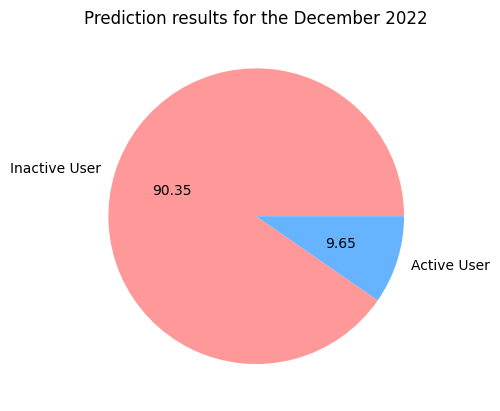

In [ ]:
labels = ['Inactive User', 'Active User']

# Visualisation of the results
pred_DataFrame.value_counts().plot.pie(labels=labels, autopct = '%.2f',  colors=['#ff9999','#66b3ff'])

plt.title('Prediction results for the December 2022')

# Remove the y-axis label
plt.ylabel('')

**7A)** Explain: why do you think this is the optimal model? What can you tell about the predicitions for December? What should Telenet do with them. Use Data understanding techniques on the new predictions to support your explanation.

In this section, the percentage of active users will vary based on the volume of data analyzed.

We've chosen the stacked model for deployment because it integrates the strengths of two effective models. Optimized through cross-validation, this model is expected to perform robustly in real-world applications.

With the prediction that approximately 9.65% of November users will start using the app in December, Telenet is advised to closely monitor actual app usage during December to validate the model's performance. If the observed data closely matches our predictions, this will confirm the model's reliability. Conversely, discrepancies between predicted and actual usage can provide valuable insights, prompting further refinements to enhance the model's accuracy for future iterations.

Understanding user behavior from these predictions is crucial for Telenet, enabling more precise tailoring of marketing strategies to boost user engagement and potentially introduce targeted promotions to enhance new app usage.

Consider a scenario where Telenet has conducted an advertising campaign based on the current model's predictions. By examining the uptick in app usage post-campaign against the forecasted figures, Telenet can gauge the campaign's success and its impact on user behavior. This integration of predictive analytics with marketing data could lead to more data-informed decisions, optimizing ad spending to focus on the most effective strategies.

Insert the dataframe/array with your predictions in the code below (at the spot of "y_pred_dec"). After succesfully running the cell, you should find the csv in your Google Drive.

In [54]:
# drive.mount('/content/drive')
# path = '/content/drive/My Drive/submission_group4.csv'          #write the group number before .csv

# with open(path, 'w', encoding = 'utf-8-sig') as submission_group4:
#   pred_DataFrame.to_csv(submission_group4)                #write group number after the word group

# Capture the end time
end_time = time.time()

# Calculate the duration
duration = end_time - start_time

# Get the machine name
machine_name = socket.gethostname()

# Print the duration
print(f"Notebook took {duration:.2f} seconds to run.")

# Write the duration and machine name to a text file
with open("execution_time_log.txt", "a") as file:
    file.write(f"Machine: {machine_name}, Duration: {duration:.2f} seconds\n")


Notebook took 4135.36 seconds to run.


**7B)** According to you, what are the three most important limitations of the presented analysis/method? Explain in detail.

Firstly, as noted in the introduction, the dataset is biased because it only includes data from individuals who consented to data collection. To enhance the generalizability of the results, it would be preferable for the data to be truly random across all of Telenet's customers.

Secondly, in our analysis, we have not explored the descriptive columns of the dataset. These columns often contain rich, unstructured text data that could provide valuable insights when analyzed properly. By applying text mining techniques, we could extract meaningful patterns or features that might significantly enhance the predictive performance of our models.

Lastly, an important limitation concerns the models we have built. In data science, there is no such thing as a free lunch, meaning there is no guarantee that the chosen models are the optimal solution for the task assigned to us by Telenet.